In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 57.1 MB/s 
     |████████████████████████████████| 6.6 MB 60.4 MB/s 


In [ ]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pd.__version__

'1.3.5'

## Coleta dos dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
folder = '/content/drive/MyDrive/Best_model'

In [ ]:
data = pd.read_csv('dataset_atualizado_06062022_aleatorio.csv')

#data.drop_duplicates(['comentarios'], inplace=True)
#data=data.sample(frac=1).reset_index(drop=True)

In [ ]:
#data = data.loc[(data['rotulacao_manual'] == 1) | (data['rotulacao_manual']==-1)]

In [ ]:
data

In [ ]:
data.loc[data['rotulacao_manual'] == -1, 'rotulacao_manual'] = 2
#data.loc[data['rotulacao_manual'] == -1, 'rotulacao_manual'] = 0

In [ ]:
data['rotulacao_manual'].value_counts()

0    2176
2    1213
1    1078
Name: rotulacao_manual, dtype: int64

In [ ]:
#for i in data.rotulacao_manual.values:
#  print(i)

## Pré-processamento dos dados

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertConfig, RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer, AutoModel

In [ ]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-large-portuguese-cased'
#PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'


#tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
sample_txt = 'Quem conta um conto aumenta um ponto'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Quem conta um conto aumenta um ponto
   Tokens: ['Quem', 'conta', 'um', 'conto', 'aumenta', 'um', 'ponto']
Token IDs: [15807, 1284, 222, 12059, 8101, 222, 2009]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=16,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids']

16


tensor([[  101, 15807,  1284,   222, 12059,  8101,   222,  2009,   102,     0,
             0,     0,     0,     0,     0,     0]])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Quem', 'conta', 'um', 'conto', 'aumenta', 'um', 'ponto', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
token_lens = []

for txt in data.comentarios:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


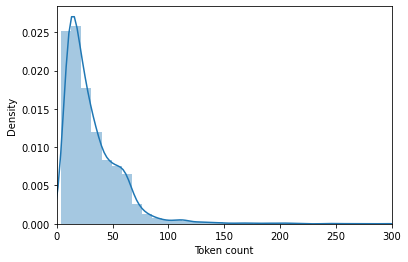

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 300]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 180

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
RANDOM_SEED

42

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, shuffle=False)

In [ ]:
import imblearn
from collections import Counter
counter = Counter(df_train['rotulacao_manual'].values)
print(counter)

Counter({0: 1746, 2: 969, 1: 858})


#### Save train and test

In [ ]:
import pickle

In [ ]:
pickle.dump(df_train, open('/content/drive/MyDrive/Best_model/pickle/df_train_RoBERTa_0606.pickle', 'wb'))
pickle.dump(df_test, open('/content/drive/MyDrive/Best_model/pickle/df_test_RoBERTa_0606.pickle', 'wb'))
#pickle.dump(df_val, open('/content/drive/MyDrive/Best_model/pickle/df_val_BERTimabu_0606.pickle', 'wb'))

#### Load train and test

In [ ]:
def read_pickle(name):
    one_instance = None
    with (open(name,'rb')) as openfile:
        while True:
            try:
                one_instance = pickle.load(openfile)
            except EOFError:
                break
    print(type(one_instance))
    one_instance = one_instance
    return one_instance

In [ ]:
# df_train = read_pickle('/content/drive/MyDrive/Best_model/pickle/df_train.pickle')
# df_test = read_pickle('/content/drive/MyDrive/Best_model/pickle/df_test.pickle')
# df_val = read_pickle('/content/drive/MyDrive/Best_model/pickle/df_val.pickle')

df_train = read_pickle('df_train_bert_1003.pickle')
df_test = read_pickle('df_test_bert_1003.pickle')
df_val = read_pickle('df_val_bert_1003.pickle')


In [ ]:
pickle.loads('df_train_bert_1003.pickle')

#### ...

In [ ]:
df_train.shape, df_test.shape

((2400, 8), (600, 8))

In [ ]:
counter = Counter(df_test['rotulacao_manual'].values)
print(counter)

Counter({0: 430, 2: 244, 1: 220})


In [ ]:
df_train

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.comentarios.to_numpy(),
    targets=df.rotulacao_manual.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
#val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_data_loader

In [ ]:
dt = next(iter(train_data_loader))
dt

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[  101,  1469,   122,  ...,     0,     0,     0],
         [  101,  1061, 16352,  ...,     0,     0,     0],
         [  101,  9414,  1101,  ...,     0,     0,     0],
         ...,
         [  101,  1288,   291,  ...,     0,     0,     0],
         [  101, 19687, 19623,  ...,   119,  3396,   102],
         [  101,  2448,   252,  ...,     0,     0,     0]]),
 'review_text': ['el ejército de brasil, que está a cargo de la seguridad pública en rio de janeiro desde el año pasado, fusiló a un músico que iba en auto con su familia dispararon más 80 tiros',
  'eles derrubaram uma adulta em cima de um bebê',
  'zero pessoas gostam da polícia',
  'a pmmg na minha opinião e uma das polícias mais despreparada do brasil, isso e vergonh

In [ ]:
print(dt['input_ids'].shape)
print(dt['attention_mask'].shape)
print(dt['targets'].shape)

torch.Size([8, 180])
torch.Size([8, 180])
torch.Size([8])


In [ ]:
print(dt['input_ids'])

tensor([[  101,  1469,   122,  ...,     0,     0,     0],
        [  101,  1061, 16352,  ...,     0,     0,     0],
        [  101,  9414,  1101,  ...,     0,     0,     0],
        ...,
        [  101,  1288,   291,  ...,     0,     0,     0],
        [  101, 19687, 19623,  ...,   119,  3396,   102],
        [  101,  2448,   252,  ...,     0,     0,     0]])


## Classificação de Sentimento

In [ ]:
import torch.nn as nn
import gc

In [ ]:
class BERT_CNN(nn.Module):

    def __init__(self, n_classes):
        super(BERT_CNN, self).__init__()
        self.bert = BertModel.from_pretrained('neuralmind/bert-large-portuguese-cased')
        self.conv = nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 768), padding=True)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(442, 3) # before : 442 with max_length 36 # 806 with max_length 64
        self.flat = nn.Flatten()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, _, all_layers = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        # all_layers  = [13, 32, 64, 768]
        x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers]), 0), 0, 1)
        del all_layers
        gc.collect()
        torch.cuda.empty_cache()
        x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))
        x = self.fc(self.dropout(self.flat(self.dropout(x))))
        return self.softmax(x)

In [ ]:
class SentimentClassifier(torch.nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
    config.num_labels = 3
    config.return_dict = False
    #self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)
    self.drop = torch.nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = BERT_CNN(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Treinamento

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from collections import defaultdict

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  if train_acc > best_accuracy:
    torch.save(model.state_dict(),'geral_BERTimbau_06062022.bin')
    best_accuracy = train_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

AttributeError: ignored

In [ ]:
#model

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.6966666666666667

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.37      0.43       166
           1       0.00      0.00      0.00        26
           2       0.75      0.87      0.81       408

    accuracy                           0.70       600
   macro avg       0.42      0.42      0.41       600
weighted avg       0.65      0.70      0.67       600



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
len(y_test)

600

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
metricas = pd.DataFrame(report).transpose()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metricas

,precision,recall,f1-score,support
0,0.500000,0.373494,0.427586,166.000000
1,0.000000,0.000000,0.000000,26.000000
2,0.747899,0.872549,0.805430,408.000000
accuracy,0.696667,0.696667,0.696667,0.696667
macro avg,0.415966,0.415348,0.411005,600.000000
weighted avg,0.646905,0.696667,0.665991,600.000000


In [ ]:
metricas.iloc[[2]].values[0]

array([  0.43971631,   0.53448276,   0.48249027, 232.        ])

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
def metricas_auc_roc(y_score, y_test):
  #y_score = modelo.predict_proba(X_test)

  y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
  n_classes = y_test_bin.shape[1]

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  result = []

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    result.append(auc(fpr[i], tpr[i]))
  return result

In [ ]:
metricas_auc_roc(y_pred_probs, y_test)

[0.672297484870357, 0.7068480300187617, 0.6818065767973857]

In [ ]:
def class_3_confunsion_matrix(y_test, predictions, classe):
  matrix = confusion_matrix(y_test, predictions)

  if classe == -1:
    TP = matrix[0][0]
    FN = matrix[0][1] + matrix[0][2]
    FP = matrix[1][0] + matrix[2][0]
    TN = matrix[1][1] + matrix[1][2] + matrix[2][1] + matrix[2][2]
  elif classe == 0:
    TP = matrix[1][1]
    FN = matrix[1][0] + matrix[1][2]
    FP = matrix[0][1] + matrix[2][1]
    TN = matrix[0][0] + matrix[0][2] + matrix[2][0] + matrix[2][2]
  elif classe == 1:
    TP = matrix[2][2]
    FN = matrix[2][0] + matrix[2][1]
    FP = matrix[0][2] + matrix[1][2]
    TN = matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1]
  
  return [TP, FN, FP, TN]

In [ ]:
def metricas(predictions, modelo_nome, y_test, df):
  #predictions = modelo.predict(X_test)

  report = classification_report(y_test, predictions, output_dict=True)
  metricas = pd.DataFrame(report).transpose()

  aucRoc = metricas_auc_roc(y_pred_probs, y_test)

  metricas_neg = list(metricas.iloc[[2]].values[0])
  metricas_neg.append(aucRoc[2])
  metricas_neg = metricas_neg + class_3_confunsion_matrix(y_test, predictions, -1)

  metricas_pos = list(metricas.iloc[[1]].values[0])
  metricas_pos.append(aucRoc[1])
  metricas_pos = metricas_pos + class_3_confunsion_matrix(y_test, predictions, 1)
  
  metricas_neu = list(metricas.iloc[[0]].values[0])
  metricas_neu.append(aucRoc[0])
  metricas_neu = metricas_neu + class_3_confunsion_matrix(y_test, predictions, 0)

  result = metricas_neg + metricas_pos + metricas_neu
  result = [modelo_nome] + result

  result.append(accuracy_score(y_test, predictions))

  df_aux = pd.DataFrame([result], columns=['modelo', 'precision(-1)', 'recall(-1)', 'f1-score(-1)', 'suport(-1)', 'auc-roc(-1)',  'TP(-1)', 'FN(-1)', 'FP(-1)', 'TN(-1)', 'precision(1)', 'recall(1)', 'f1-score(1)', 'suport(1)', 'auc-roc(1)', 'TP(1)', 'FN(1)', 'FP(1)', 'TN(1)', 'precision(0)', 'recall(0)', 'f1-score(0)', 'suport(0)', 'auc-roc(0)', 'TP(0)', 'FN(0)', 'FP(0)', 'TN(0)', 'accuracy'])

  return pd.concat([df_aux, df])

In [ ]:
df_metricas = pd.DataFrame(columns=['modelo', 'precision(-1)', 'recall(-1)', 'f1-score(-1)', 'suport(-1)', 'auc-roc(-1)',  'TP(-1)', 'FN(-1)', 'FP(-1)', 'TN(-1)', 'precision(1)', 'recall(1)', 'f1-score(1)', 'suport(1)', 'auc-roc(1)', 'TP(1)', 'FN(1)', 'FP(1)', 'TN(1)', 'precision(0)', 'recall(0)', 'f1-score(0)', 'suport(0)', 'auc-roc(0)', 'TP(0)', 'FN(0)', 'FP(0)', 'TN(0)', 'accuracy'])
df_metricas = metricas(y_pred, 'Rede-neural-RoBERTa', y_test, df_metricas)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_metricas

,modelo,precision(-1),recall(-1),f1-score(-1),suport(-1),auc-roc(-1),TP(-1),FN(-1),FP(-1),TN(-1),...,precision(0),recall(0),f1-score(0),suport(0),auc-roc(0),TP(0),FN(0),FP(0),TN(0),accuracy
0,Rede-neural-RoBERTa,0.747899,0.872549,0.80543,408.0,0.681807,62,104,62,372,...,0.5,0.373494,0.427586,166.0,0.672297,0,26,0,574,0.696667


In [ ]:
df_metricas.to_csv('metricas_rede_neural_roberta_0606.csv')

## confusion matrix

In [ ]:
class_names = ['neu', 'pos', 'neg']

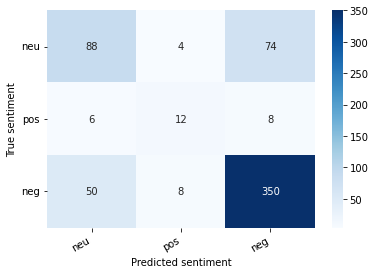

In [ ]:
def show_confusion_matriz(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matriz(df_cm)

## Texto bruto

In [ ]:
#coment_text = "Parabéns ao policial!!! ótima atuação!"
#coment_text = "Esse polical é despreparado, péssima ação policial"
#coment_text = 'Perigosa mesmo era a touca ninja... É mais um episódio de inveja da nossa PM em relação aos policiais norte-americanos. Mas podem ficar tranquilos, pessoal, não faltará oportunidade para matar um preto com o joelho no pescoço... Já houve treinamento, no assassinato de 26 em Varginha.'
coment_text = "Vejam na filmagem, aos 16s, a mãe caindo sobre o bebê, que parece bater com o rosto no chão. Não houve queda controlada, obviamente. Até quando Brasil tratará a população negra com tanto desrespeito e violência?"

In [ ]:
encoded_review = tokenizer.encode_plus(
  coment_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoded_review

{'input_ids': tensor([[   101,  19561,  36887,  10132,  29180,  20531,    117,  13851,  10250,
          10107,    117,    169,  36937,  39270,  10605,  10690,    183,  10347,
          10457,  15915,    117,  10121,  30395,  11519,  10165,  10212,    183,
          39312,  10340,  10192,  18643,  11449,    119,  31107,  68752,  28107,
          12608,  11153,    117,  17339,  82946,    119,  71935,  11971,  12264,
          51783,  10661,    169,  17857,  38455,  10212,  12921,  10139,  11234,
          76050,  10340,    173,  43005, 102698,    136,    102,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {coment_text}')
print(f'Sentiment  : {prediction[0]}')

Review text: Vejam na filmagem, aos 16s, a mãe caindo sobre o bebê, que parece bater com o rosto no chão. Não houve queda controlada, obviamente. Até quando Brasil tratará a população negra com tanto desrespeito e violência?
Sentiment  : 2
